# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque
from unityagents import UnityEnvironment
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import torch
%matplotlib inline

from agents.ddpg_agent import Agent

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Training the agent

Now the agent will be trained through experience in the environment. This agent uses a `UniformReplayBuffer` that randomly selects `BATCH_SIZE` experiences from the buffer at each step. These experiences are then used to train the both the actor and critic.

In [7]:
seed = 8

agent = Agent(state_size, action_size, num_agents, seed)

In [8]:
checkpoints_folder = 'checkpoints'
model_name = 'ddpg'

def save_model(model, suffix=''):
    file_name = f'model_{model_name}'
    if suffix:
        file_name += f'_{suffix}'
    file_path = os.path.join(checkpoints_folder, f'{file_name}.pth')
    torch.save(model.state_dict(), file_path)
def save_scores(scores):
    file_name = f'score_{model_name}'
    file_path = os.path.join(checkpoints_folder, f'{file_name}.pkl')
    pickle.dump(scores, open(file_path, 'wb'))
def step_env(action):
    env_info = env.step(action)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    return (next_states, rewards, dones, None)

In [9]:
def ddpg(n_episodes=3500, max_t=1000, print_every=10):
    scores_deque = deque(maxlen=100)
    scores = []
    for i_episode in range(1, n_episodes+1):
        max_achieved_score = 0
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(num_agents)
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)
            next_states, rewards, dones, _ = step_env(actions)
            
            agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if any(dones):
                break
         
        max_score = np.max(score)
        scores_deque.append(max_score)
        scores.append(max_score)
        
        mean_score = np.mean(scores_deque)
        if mean_score > 0.5 and max_achieved_score < mean_score:
            max_achieved_score = mean_score
            save_model(agent.actor_local, 'actor')
            save_model(agent.critic_local, 'critic')
            save_scores(scores)

        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, mean_score))
    
    save_scores(scores)
    
    return scores

scores = ddpg()

Episode 10	Average Score: 0.02
Episode 20	Average Score: 0.01
Episode 30	Average Score: 0.01
Episode 40	Average Score: 0.01
Episode 50	Average Score: 0.01
Episode 60	Average Score: 0.00
Episode 70	Average Score: 0.00
Episode 80	Average Score: 0.01
Episode 90	Average Score: 0.01
Episode 100	Average Score: 0.01
Episode 110	Average Score: 0.01
Episode 120	Average Score: 0.01
Episode 130	Average Score: 0.01
Episode 140	Average Score: 0.02
Episode 150	Average Score: 0.02
Episode 160	Average Score: 0.02
Episode 170	Average Score: 0.03
Episode 180	Average Score: 0.03
Episode 190	Average Score: 0.02
Episode 200	Average Score: 0.02
Episode 210	Average Score: 0.02
Episode 220	Average Score: 0.02
Episode 230	Average Score: 0.03
Episode 240	Average Score: 0.03
Episode 250	Average Score: 0.03
Episode 260	Average Score: 0.03
Episode 270	Average Score: 0.02
Episode 280	Average Score: 0.02
Episode 290	Average Score: 0.02
Episode 300	Average Score: 0.02
Episode 310	Average Score: 0.02
Episode 320	Avera

Episode 2530	Average Score: 0.58
Episode 2540	Average Score: 0.62
Episode 2550	Average Score: 0.62
Episode 2560	Average Score: 0.64
Episode 2570	Average Score: 0.66
Episode 2580	Average Score: 0.68
Episode 2590	Average Score: 0.71
Episode 2600	Average Score: 0.72
Episode 2610	Average Score: 0.77
Episode 2620	Average Score: 0.77
Episode 2630	Average Score: 0.80
Episode 2640	Average Score: 0.83
Episode 2650	Average Score: 0.88
Episode 2660	Average Score: 0.86
Episode 2670	Average Score: 0.87
Episode 2680	Average Score: 0.82
Episode 2690	Average Score: 0.85
Episode 2700	Average Score: 0.87
Episode 2710	Average Score: 0.82
Episode 2720	Average Score: 0.77
Episode 2730	Average Score: 0.78
Episode 2740	Average Score: 0.76
Episode 2750	Average Score: 0.73
Episode 2760	Average Score: 0.74
Episode 2770	Average Score: 0.73
Episode 2780	Average Score: 0.73
Episode 2790	Average Score: 0.66
Episode 2800	Average Score: 0.63
Episode 2810	Average Score: 0.65
Episode 2820	Average Score: 0.68
Episode 28

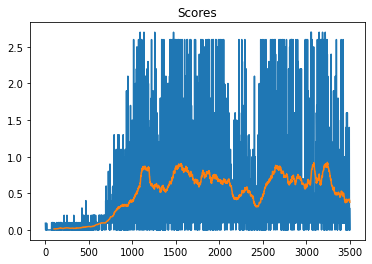

In [10]:
def plot_scores(scores, rolling_window=100):
    """Plot scores and optional rolling mean using specified window."""
    plt.plot(scores); plt.title("Scores");
    rolling_mean = pd.Series(scores).rolling(rolling_window).mean()
    plt.plot(rolling_mean);
    return rolling_mean

rolling_mean = plot_scores(scores)